<a href="https://colab.research.google.com/github/TheLemonPig/RL-SSM/blob/main/RL_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

There is some code hidden in folders in this notebook that need to be run but do not need to be looked inside for testing. It will be made clear which is which. These exist because I can't figure out how to make the repo this comes from something I can import into Google Colab.

## 1. Install Packages - run without opening

In [1]:
# # restart runtime after running and skip this cell
# !pip install 'pymc>=5.9'
# !pip install numpyro
# !pip install git+https://github.com/lnccbrown/hssm@main
# !pip install git+https://github.com/brown-ccv/hddm-wfpt@main

##2. Import Packages - run without opening

In [2]:
import numpyro
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import functools
from scipy.optimize import curve_fit
import pymc as pm
import arviz as az
from typing import List, Callable
from functools import partial
from tqdm import tqdm
import bambi as bmb
import itertools
import hddm_wfpt
import hssm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


##3. Create Synthetic RL Model - run without opening

###3a. helper functions

In [3]:
def softmax(qs, tau):
  safe_tau = np.abs(tau) + 1e-2
  return np.exp(qs/safe_tau) / np.exp(qs/safe_tau).sum()

def rescola(qt, alpha, reward):
  return qt + alpha * (reward - qt)

In [4]:
class Distribution:

  def __init__(self, func: Callable, kwargs):
    self.func: Callable = partial(func, **kwargs)

  def __call__(self):
    return self.func.__call__()

seed = 0
np.random.seed(seed)
mean_rewards = [-1.0,1.0]
dists = [Distribution(np.random.normal,{"loc":mn, "scale":1.0}) for mn in mean_rewards]

###3b. Single participant RL model

In [5]:
class SimpleRL:

  def __init__(self, n_trials: int, distributions: List[Distribution]):
    self.n_choices: int = len(distributions)
    self.n_trials: int = n_trials
    self.distributions: List[Distribution] = distributions
    self.qs: np.array = np.ones((self.n_choices,)) * 0.5
    self.q_trace: np.array = np.ones((self.n_trials,self.n_choices))
    self.rewards: np.array = np.zeros((self.n_trials))
    self.choices: np.array = np.zeros((self.n_trials),dtype=np.int32)

  def simulate(self, alpha, temperature):
    for i in range(self.n_trials):
      # Q-values are recorded to trace
      self.q_trace[i] = self.qs
      # softmax decision function
      ps = softmax(self.qs,temperature)
      # choice made based on weighted probabilities of Q-values
      choice = np.random.choice(a=self.n_choices,size=1,p=ps)[0]
      # choice is recorded to trace
      self.choices[i] = choice
      # reward calculated
      dist = self.distributions[choice]  # supply a list of distributions to choose from
      reward = dist()  # sample from distribution by calling it
      # Q-values updated
      self.rewards[i] = reward
      self.qs[choice] = rescola(self.qs[choice],alpha,reward)
    # Q-values trace returned
    # main data to be returned (basis for fits), is choices and rewards per trial
    return self.rewards, self.choices

###3c. Multiple Participants RL Model

In [6]:
class MultiRL:

  def __init__(self, n_trials: int, n_participants: int, distributions: List[Distribution]):
    self.participants: List[SimpleRL] = [
        SimpleRL(n_trials, distributions) for _ in range(n_participants)
    ]
    self.alphas = list()
    self.temperatures = list()

  def simulate(self, alpha_a, alpha_b, temperature_a, temperature_b):
    group_data = []
    for idx, participant_model in enumerate(self.participants):
      # sample participant parameters
      alpha = np.random.beta(alpha_a, alpha_b)
      temperature = np.random.beta(temperature_a, temperature_b)
      self.alphas.append(alpha)
      self.temperatures.append(temperature)
      participant_rewards, participants_choices = np.vstack(participant_model.simulate(alpha, temperature))
      assert sum(np.isnan(participant_rewards)) == 0, participant_rewards
      trial_col = np.arange(participant_model.n_trials).reshape((-1,1))
      idx_col = np.ones_like(trial_col) * idx
      group_data.append(np.concatenate([idx_col,participant_rewards.reshape((-1,1)),participants_choices.reshape((-1,1)),trial_col],axis=1))
    return np.concatenate(group_data)

  def get_params(self):
    return self.alphas, self.temperatures


##4. Define PyTensor Model - everything past here is worth looking at

###4a. First multiloglikelihood function

This function was written many months ago and was tested on PyMC. Since then parameters QM and mll have been moved to being initialize internally instead of passed in to make it easier to use.

A and B are expected to be vectors over participants

CM and RM are expected to be tensors over trials, participants, and choices

A and B are first preprocessed to repeat their values over a second dimension for choices, so that they match the shapes of the other variables within the scan function

The first scan loop iterates over trials, with kernel shape (n_participants, n_choices):
- one-hotted choices
- rewards (repeated in choice dimension so that elementwise multiplication works properly)
It takes A as a non-sequence variable - one for each participant
It takes a Q variable of the same shape as A and outputs a variable the same shape as the rewards and choices, which is the Q-values over participants and trials

The second scan loop iterates over trials, with kernel shape (n_participants, n_choices):
- one-hotted choices
- Q-values of the same shape
It takes B as a non-sequence variable - one for each participant
It takes a mll variable of the same shape as B and outputs a variable the same shape as the Qs and choices, which is the loglikelihood values over participants and trials

This function does not currently flatten the loglikelihoods. This can be changed if you want to test this function without a wrapper function

In [7]:
# parameters & variables
CM = pt.itensor3("CM") # choice matrices OVER PARTICIPANTS
RM = pt.dtensor3("RM") # reward matrices OVER PARTICIPANTS
# QM = pt.dmatrix("QM") # empty vectors to store q-values across trials OVER PARTICIPANTS
A = pt.dvector("A") # scalars of learning rates OVER PARTICIPANTS
B = pt.dvector("B") # scalars of RL decision temperatures OVER PARTICIPANTS
# mll = pt.dvector("mll")  # empty scalars to store ll value OVER PARTICIPANTS

def my_mll_func(CM, RM, A, B):

    # function for a single RL step
    # C: vector (participants, choices)
    # R: vector (participants, choices)
    # Q_tm1: matrix (participants, choices)
    # A: vector (participants, choices)
    def rl_step(C, R, Q_tm1, A):
        return Q_tm1 + pt.mul(A,pt.mul(C,(R - Q_tm1)))

    ### function to calculate loglikehood for each trial
    # C: matrix (participants, choices)
    # Qs: matrix (participants, choices)
    # B: vector (participants, choices)
    ## Ps: matrix
    ## P_select: vector
    # mll: vector
    def ll_def(C, Qs, mll, B):
        denom = pt.exp(pt.true_div(Qs,B)).sum(axis=1)
        denom = pt.repeat(denom.reshape((denom.shape[0],1)),n_choices,axis=1)
        Ps = pt.true_div(
             pt.exp(pt.true_div(Qs,B)),
             denom
             )
        P_select = pt.mul(Ps,C).sum(axis=1)  # sum over choices
        mll = pt.log(P_select)
        return mll

    n_choices = CM.shape[-1]
    mll = pt.zeros((A.shape[0]))
    QM = pt.ones((A.shape[0], n_choices)) * 0.5
    A = A.reshape((A.shape[0],1))
    B = B.reshape((B.shape[0],1))
    AM = pt.repeat(A,n_choices,axis=1)
    BM = pt.repeat(B,n_choices,axis=1)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # RM: tensor3 [matrix] (trials,[participants, choices])
    # A: matrix (participants, choices)
    # QM: matrix (participants, choices) --> tensor3 (trials, participants, choices)
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM], non_sequences = [AM], outputs_info=QM)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # QsT3: tensor3 [matrix] (trials, [participants, choices])
    # B: matrix (participants, choices)
    # mll: scalar --> vector
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3], non_sequences=[BM], outputs_info=mll)

    return loglikes

loglikes = my_mll_func(CM, RM, A,B)

mloglike_func = pytensor.function(inputs=[CM,RM,A,B],outputs=loglikes)

### 4b. Second multiloglikehood function

This function was written very recently based on an updated understanding of how the hierarchical regressors work. It is almost identical to the function above. Those differences are:

A and B are expected to be matrices over trials and participants

A and B are still reshaped to repeat over a choice dimension but now this is their 3rd dimension rather than their 2nd dimension

A and B are no longer passed as non-sequences. Instead they are passed as sequnce variables along with CM and RM. After reshaping, all 4 input variables have shape (n_trials, n_participants, n_choices).

This change requires a rearrangement of arguments when defining the functions. However, within the function, their shape is the same as it was in the previous function, and so the internal details of the functions are unchanged.

In [8]:
# parameters & variables
CM = pt.itensor3("CM") # choice matrices OVER PARTICIPANTS
RM = pt.dtensor3("RM") # reward matrices OVER PARTICIPANTS
# QM = pt.dmatrix("QM") # empty vectors to store q-values across trials OVER PARTICIPANTS
A = pt.dmatrix("A") # scalars of learning rates OVER PARTICIPANTS
B = pt.dmatrix("B") # scalars of RL decision temperatures OVER PARTICIPANTS
# mll = pt.dvector("mll")  # empty scalars to store ll value OVER PARTICIPANTS

def my_mll2_func(CM, RM, A, B):

    # function for a single RL step
    # C: vector (participants, choices)
    # R: vector (participants, choices)
    # Q_tm1: matrix (participants, choices)
    # A: vector (participants, choices)
    def rl_step(C, R, A, Q_tm1):
        return Q_tm1 + pt.mul(A,pt.mul(C,(R - Q_tm1)))

    ### function to calculate loglikehood for each trial
    # C: matrix (participants, choices)
    # Qs: matrix (participants, choices)
    # B: vector (participants, choices)
    ## Ps: matrix
    ## P_select: vector
    # mll: vector
    def ll_def(C, Qs, B, mll):
        denom = pt.exp(pt.true_div(Qs,B)).sum(axis=1)
        denom = pt.repeat(denom.reshape((denom.shape[0],1)),n_choices,axis=1)
        Ps = pt.true_div(
             pt.exp(pt.true_div(Qs,B)),
             denom
             )
        P_select = pt.mul(Ps,C).sum(axis=1)  # sum over choices
        mll = pt.log(P_select)
        return mll

    n_choices = 2
    n_participants = A.shape[1]
    mll = pt.zeros((n_participants),dtype='float64')
    QM = pt.ones((n_participants, n_choices),dtype='float64') * 0.5
    # RM = pt.mul(RM,pt.ones_like((QM.shape[0])))
    A = A.reshape((A.shape[0],A.shape[1],1))
    B = B.reshape((B.shape[0],B.shape[1],1))
    AM = pt.repeat(A,n_choices,axis=2)
    BM = pt.repeat(B,n_choices,axis=2)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # RM: tensor3 [matrix] (trials,[participants, choices])
    # A: matrix (participants, choices)
    # QM: matrix (participants, choices) --> tensor3 (trials, participants, choices)
    QsT3, updates = pytensor.scan(rl_step, sequences=[CM,RM,AM], non_sequences = [], outputs_info=QM)

    ### scan function
    # CM: tensor3 [matrix] (trials,[participants, choices])
    # QsT3: tensor3 [matrix] (trials, [participants, choices])
    # B: matrix (participants, choices)
    # mll: scalar --> vector
    loglikes, updates = pytensor.scan(ll_def, sequences=[CM,QsT3,BM], non_sequences=[], outputs_info=mll)

    return loglikes

output = my_mll2_func(CM, RM, A, B)

mloglike_func2 = pytensor.function(inputs=[CM,RM,A,B],outputs=output)

###4c. Test cell (optional)

You can use this to test whether the loglikelihood functions are working.

For example, here you can see that the second loop is working because when there is no learing rate (first participant), all of the loglikelihoods are equal to log(0.5) ~= -0.693 ---- Q values are initialized to 0.5

In [9]:
# Test parameters
np.random.seed(0)
n_choices = 2
n_trials = 10
n_participants = 5
mll_test = np.zeros((n_participants,))
C_test = np.array(np.random.randint(low=0,high=n_choices,size=(n_trials,)), dtype=np.int32)
C_test_onehot = np.array(np.eye(n_choices)[C_test],dtype=np.int32)  # Remember to use this one
R_test = np.ones((n_trials,), dtype=np.int32) - 2 * C_test
R_test = np.repeat(R_test[:,np.newaxis],n_choices,axis=1)
a_test = 0.1
b_test = 1.0
CM_test_onehot = np.repeat(C_test_onehot[:,np.newaxis,:],n_participants,axis=1)
RM_test_repeat = np.repeat(R_test[:,np.newaxis,:],n_participants,axis=1)
A_test = np.array([0.0,0.1,0.2,0.3,0.4])
# A_test = np.tile(a_test,(n_participants,))  # for mloglike_func
B_test = np.tile(b_test,(n_participants,))  # for mloglike_func
# A_test = np.tile(a_test,(n_trials, n_participants))  # for mloglike_func2
# B_test = np.tile(b_test,(n_trials, n_participants,))  # for mloglike_func2

# RL Loglikelihood function test
mloglike_func(CM_test_onehot,RM_test_repeat,A_test,B_test)
#mloglike_func2(CM_test_onehot,RM_test_repeat,A_test,B_test)

array([[-0.69314718, -0.66845965, -0.64439666, -0.62095705, -0.59813887],
       [-0.69314718, -0.79813887, -0.91301525, -1.03748795, -1.17110067],
       [-0.69314718, -0.8746102 , -1.06349651, -1.25184119, -1.43268481],
       [-0.69314718, -0.52108961, -0.39659405, -0.30792206, -0.24532554],
       [-0.69314718, -0.97501094, -1.24970004, -1.49455256, -1.69814417],
       [-0.69314718, -1.04450677, -1.36163788, -1.61628827, -1.80524595],
       [-0.69314718, -1.10938631, -1.45444089, -1.70378078, -1.87062776],
       [-0.69314718, -1.16960979, -1.53063759, -1.76606677, -1.91023778],
       [-0.69314718, -1.22524829, -1.59277916, -1.81015187, -1.93413616],
       [-0.69314718, -1.27645109, -1.64321608, -1.8412405 , -1.94852182]])

##5. Create PyMC Model

###5a. Create Synthetic Data using Synthetic Model - these cells are really important for formatting

####5ai. simulate model - I would run without looking and look into the output data directly if you have any concerns

In [16]:
n_trials = 50
n_participants = 3
n_choices = len(dists)
multi_rl_model = MultiRL(n_trials=n_trials,n_participants=n_participants,distributions=dists)
data = multi_rl_model.simulate(alpha_a=2.0,alpha_b=5.0,temperature_a=2.0,temperature_b=2.0)

In [17]:
df = pd.DataFrame(data=data,columns=['participant_id','rewards','choices','trial'])
df['rt'] = 0
df['response'] = 0
n_participants = len(df['participant_id'].unique())
C = np.array(df['choices'],dtype=np.int32)
C_onehot = np.array(np.eye(n_choices)[C],dtype=np.int32)
df['choice_0'] = C_onehot[:,0]
df['choice_1'] = C_onehot[:,1]
del df['choices']
df['participant_id'] = df['participant_id'].apply(lambda x: int(x))
df['n_participants'] = df['participant_id'].max() + 1
df['participant_id'] = df['participant_id'].apply(lambda x: str(x))

####5aii. reformat data - I would look in here briefly

NOTE: ALL OF THIS CAN BE REMOVED ONCE WE CAN GET DIMSHUFFLE WORKING

Inverting data so that when it is reshaped by the wrapper function the data is correctly organized

In [28]:
# creating dummy alphas and betas
alphas = (np.ones((df.shape[0])) * 0.1).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
betas = (np.ones((df.shape[0])) * 0.1).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
# turning the data into numpy arrays
choice_0 = np.array(df['choice_0'], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
choice_1 = np.array(df['choice_1'], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
rewards = np.array(df['rewards'], dtype=np.float64).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')
participants = np.array(df['participant_id'], dtype=np.int32).reshape((n_participants,n_trials),order='A').reshape((n_trials*n_participants,),order='F')

You can test that it is inverted correctly with this next cell. This cell replicates how reshaping will happen inside of the wrapper model

In [29]:
participants.reshape((n_trials,n_participants))[:10]

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]], dtype=int32)

###5b. Create wrapper loglikelihood functions - these cells are really important (most likely to have the error)

####5bi. Wrapper for first likelihood function

IMPORTANT OPTION TOGGLE INSIDE!!

- The first function header is required to compile the model outside of pymc/hssm

- The second function header is required to compile inside of hssm

This is because the function doesn't currently call data and so it will not compile with it as an argument in the header

Within this wrapper, there are 4 main preprocessing steps:
  1. Parameter values the number of participants, trials, and trials are calculated (or hard coded for now)
  2. ALL variables taken into the function are reshaped
    - from: (n_participants * n_trials,)
    - to: (n_participants , n_trials)
  3. the maximum value for each participant is taken from the reshaped alphas and betas - reshaping
    - from: (n_participants , n_trials)
    - to: (n_participants,)
  4. Reward and Choice vectors are repeated/stacked respectively into three dimensional tensors of shape (n_participants , n_trials, n_choices)

In [85]:
def my_hdll(alphas, betas, choice_0, choice_1, rewards, participants):
#def my_hdll(data, alphas, betas, choice_0, choice_1, rewards,participants):
    R = rewards
    n_participants = pt.cast(pt.max(participants)+1, 'int32')  # 3
    n_trials = 50
    n_choices = 2
    # IT TURNS OUT YOU NEED TO COMMENT THESE OUT FOR PYMC
    # shaped_alphas = alphas.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    # shaped_betas = betas.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    # alphas = pt.max(shaped_alphas,axis=0).flatten()
    # betas = pt.max(shaped_betas,axis=0).flatten()
    choice_0 = choice_0.reshape((n_trials,n_participants))  # reshape((n_participants,n_trials)).dimshuffle([1,0])
    choice_1 = choice_1.reshape((n_trials,n_participants))  # reshape((n_participants,n_trials)).dimshuffle([1,0])
    Cs = pt.stack([choice_0,choice_1],axis=-1)
    R = R.reshape((n_trials,n_participants))  # reshape((n_participants,n_trials)).dimshuffle([1,0])
    R = R.reshape((R.shape[0],R.shape[1],1))  # reshape((R.shape[0],R.shape[1],1)).dimshuffle([0,1,2])
    RM = pt.repeat(R,n_choices,axis=2)
    CM = Cs
    return my_mll_func(CM,RM,alphas,betas).flatten()

####5bii. Wrapper for second likelihood function

IMPORTANT OPTION TOGGLE INSIDE!!

This function is identical to the one above except step 3 is skipped and the variables are instead passed to the second likelihood function

In [93]:
def my_hdll2(alphas, betas, choice_0, choice_1, rewards,participants):
    R = rewards
    n_participants = pt.cast(pt.max(participants)+1, 'int32')
    n_trials = pt.constant(50,dtype=np.int32)
    n_choices = pt.constant(2,dtype=np.int32)
    # IT TURNS OUT YOU NEED TO COMMENT THESE OUT FOR PYMC
    # shaped_alphas = alphas.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    # shaped_betas = betas.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    # alphas = shaped_alphas
    # betas = shaped_betas
    # YOU WILL NEED TO RECOMMENT THESE NEXT TWO LINES IF YOU WANT TO RUN IT WITH HSSM
    alphas = pt.repeat(alphas.reshape((1,n_participants)),n_trials,axis=0)
    betas = pt.repeat(betas.reshape((1,n_participants)),n_trials,axis=0)
    # EVERYTHING BELOW IS UNAFFECTED
    choice_0 = choice_0.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    choice_1 = choice_1.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    Cs = pt.stack([choice_0,choice_1],axis=-1)
    R = R.reshape((n_trials,n_participants)) # reshape((n_participants,n_trials)).dimshuffle([1,0])
    R = R.reshape((n_trials,n_participants,1))  # reshape((R.shape[0],R.shape[1],1)).dimshuffle([0,1,2])
    RM = pt.repeat(R,n_choices,axis=2)
    CM=Cs
    return my_mll2_func(CM,RM,alphas,betas).flatten()

###5c. Make PyMC model

In [94]:
participant_ids, participants = pd.factorize(df['participant_id'])
coords = {
    "Participant": participants,
    "obs_id": np.arange(len(participant_ids)),
}
with pm.Model(coords=coords) as hierarchical_model:
    # Data
    CM1 = pm.ConstantData('myCM', choice_0)  # df['choice_0']
    CM2 = pm.ConstantData('myCM2', choice_1)  # df['choice_1']
    RM = pm.ConstantData('myRM', rewards)   # df['rewards']
    P = pm.ConstantData('myP', participants)  # df['participant_id']

    # Hyperpriors for group nodes
    alpha_a = pm.Gamma("alpha_a", alpha = 3. , beta = 0.5)
    alpha_b = pm.Gamma("alpha_b", alpha = 3. , beta = 0.5)
    beta_a = pm.Gamma("beta_a", alpha = 3. , beta = 0.5)
    beta_b = pm.Gamma("beta_b", alpha = 3. , beta = 0.5)

    # Priors for alphas and betas
    A = pm.Beta(name="A",alpha=alpha_a,beta=alpha_b,dims="Participant")
    B = pm.Beta(name="B",alpha=beta_a,beta=beta_b,dims="Participant")

    # CHOOSE WHICH WRAPPER FUNCTION TO USE HERE
    #pm.Potential("likelihood", my_hdll(A, B, CM1, CM2, RM, P))
    pm.Potential("likelihood", my_hdll2(A, B, CM1, CM2, RM, P))

    idata_mh = pm.sample(2000, tune=1000, chains=1, nuts_sampler="numpyro")

sample: 100%|██████████| 3000/3000 [00:12<00:00, 242.39it/s, 15 steps of size 2.92e-01. acc. prob=0.86]


###5d. Results

array([[<Axes: title={'center': 'alpha_a'}>,
        <Axes: title={'center': 'alpha_a'}>],
       [<Axes: title={'center': 'alpha_b'}>,
        <Axes: title={'center': 'alpha_b'}>],
       [<Axes: title={'center': 'beta_a'}>,
        <Axes: title={'center': 'beta_a'}>],
       [<Axes: title={'center': 'beta_b'}>,
        <Axes: title={'center': 'beta_b'}>],
       [<Axes: title={'center': 'A'}>, <Axes: title={'center': 'A'}>],
       [<Axes: title={'center': 'B'}>, <Axes: title={'center': 'B'}>]],
      dtype=object)

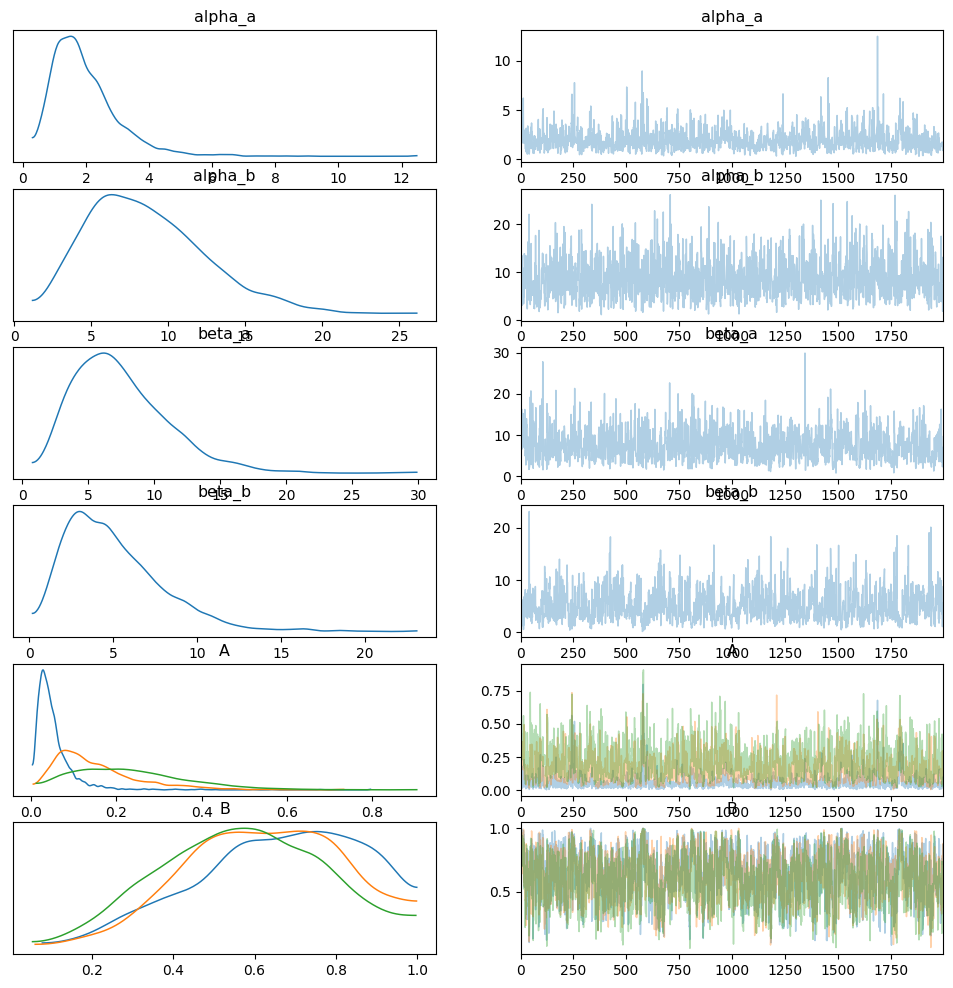

In [95]:
pm.plot_trace(idata_mh)

Results can be added here. All results can be found in previous versions of this file

##6. Integrate with HSSM - here for convenience (delete if needed)

I left this here for convenience sake

In [ ]:
def make_generalized_sigmoid_simple(a,b):
    def invlink_(x):
        return a + ((b - a) / (1 + pt.exp(-x)))
    return invlink_

def make_generalized_logit_simple(a,b):
    def link_(x):
        return pt.log((x - a) / (b - x))
    return link_

def build_generalized_sigmoid_links_simple(a,b):
    invlink_ = make_generalized_sigmoid_simple(a,b)
    link_ = make_generalized_logit_simple(a,b)
    return {'name': 'generalized_logit',
            'link': link_,
            'linkinv': invlink_,
            'linkinv_backend': invlink_}

In [ ]:
model_config_hier={
        "list_params": ["alphas", "betas"],
        "bounds": {
            "alphas": (0,1),
            "betas": (0.1,1),
        },
        "extra_fields": ['choice_0','choice_1','rewards','n_participants'],
        "backend": "numpyro"
    }
model = hssm.HSSM(
    data=hier_data,
    model="rl",
    hierarchical=False,
    loglik=my_hdll,
    loglik_kind="approx_differentiable",
    # analytical
    model_config=model_config_hier,
    include = [
                    {
                        "name": "alphas",
                        "formula": "alphas ~ 1 + (1|participant_id)", # + (1|participant_id)
                        "link": bmb.Link(**build_generalized_sigmoid_links_simple(model_config_hier['bounds']['alphas'][0],model_config_hier['bounds']['alphas'][1])),
                    },
                    {
                        "name": "betas",
                        "formula": "betas ~ 1 + (1|participant_id)",
                        "link": bmb.Link(**build_generalized_sigmoid_links_simple(model_config_hier['bounds']['betas'][0],model_config_hier['bounds']['betas'][1])),
                    }
    ],
    #"extra_namespace":
    #bmb.Prior("Uniform", lower=0.0, upper=1.0, initval=0.1),
)
sample = model.sample()
#%debug sample = model.sample()